### Clustering Similar Players

In [1]:
# packages and file import
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

# wd
os.chdir('C:/Users/dalto/OneDrive/Pictures/Documents/Projects/MLB Season Model/')

In [2]:
data_02_24 = pd.read_csv('./data/cleaned/data_02_24.csv')
data_15_24 = pd.read_csv('./data/cleaned/data_15_24.csv')

fix cols

In [3]:
data_02_24 = data_02_24.drop(columns=['Unnamed: 0', 'Team'])
df = data_02_24.copy()
df = df[df['PA'] > 200]

#### Normalization
<small> all code standard across ipynb when normalization is required (I should probably refactor into .py lol)

In [4]:
def mean_year(group):
        avg = np.average(group, weights=group.index.map(lambda x: df.loc[x, 'PA']))
        return avg

In [5]:
def calculate_weighted_std(group):
    avg = np.average(group, weights=group.index.map(lambda x: df.loc[x, 'PA']))
    variance = np.average((group - avg)**2, weights=group.index.map(lambda x: df.loc[x, 'PA']))
    return np.sqrt(variance)

In [6]:
def z_scores(player_df, mean_df, std_df):
    # z scores for each stat and player, also creating a new df flow, add back names based on MLBAMID later
    z_scores = pd.DataFrame(index=player_df.index, columns=player_df.select_dtypes(include=[np.number]).columns)

    # scaled for each col
    for col in player_df.select_dtypes(include=[np.number]).columns:
        if col not in ['Season', 'MLBAMID']:  # not needed
            for idx in player_df.index:
                season = player_df.loc[idx, 'Season']
                value = player_df.loc[idx, col]
                mean = mean_df.loc[mean_df['Season'] == season, col].iloc[0]
                std = std_df.loc[std_df['Season'] == season, col].iloc[0]
                # scale so that 10 is 1 std away
                z_scores.loc[idx, col] = 100 + ((value - mean) / std * 10)

    z_scores['Season'] = player_df['Season']
    
    # cols to numeric
    for col in z_scores.columns:
        if col not in ['Season', 'MLBAMID']:
            z_scores[col] = pd.to_numeric(z_scores[col])
    
    # reinsert player names
    z_scores.insert(0, 'Name', player_df['Name']) 

    return z_scores

In [7]:
# df to store mean results
mean_values = pd.DataFrame(index=df['Season'].unique())

for col in df.select_dtypes(include=[np.number]).columns:
    if col != 'Season' and col != 'MLBAMID':  # skip meaningless numeric
        yearly_mean = df.groupby('Season')[col].apply(mean_year)
        mean_values[col] = yearly_mean

# reset and rename index
mean_values = mean_values.reset_index()
mean_values = mean_values.rename(columns={'index': 'Season'})

# sort and display
mean_values = mean_values.sort_values(by=['Season'])
mean_values.head()

,Season,PA,Age,BB%,K%,BABIP,wRC+,BsR,Off,Def,WAR,O-Swing%,Z-Swing%,O-Contact%,Z-Contact%,Contact%,SwStr%,CSW%
8,2002,517.652604,29.260241,0.090489,0.159284,0.297944,103.706149,0.250636,4.954200,-0.866976,2.128260,0.180531,0.704206,0.511190,0.862046,0.799890,0.092869,0.254455
20,2003,519.127184,29.254995,0.087979,0.153650,0.299367,104.040357,0.154505,5.098692,-0.647077,2.157392,0.219565,0.691082,0.532687,0.885631,0.804262,0.090858,0.258544
19,2004,526.277054,29.419077,0.089677,0.157629,0.302567,104.554525,0.317217,5.543365,-0.588737,2.220211,0.201095,0.693197,0.629888,0.859343,0.811200,0.086251,0.253183
1,2005,518.083199,29.279794,0.084476,0.156415,0.300535,103.685254,0.353451,4.590521,-0.928888,2.090379,0.213378,0.681760,0.554977,0.887895,0.816117,0.084686,0.253598
14,2006,524.814098,29.257283,0.087450,0.159027,0.305772,103.592430,0.211707,4.491168,-0.834050,2.078300,0.230525,0.671632,0.588956,0.891464,0.819053,0.082923,0.249662


In [8]:
# Create empty DataFrame to store results
std_values = pd.DataFrame(index=df['Season'].unique())

# Loop through numeric columns
for col in df.select_dtypes(include=[np.number]).columns:
    if col != 'Season' and col != 'MLBAMID':  # skip meaningless numeric
        yearly_std = df.groupby('Season')[col].apply(calculate_weighted_std)
        std_values[col] = yearly_std

std_values = std_values.reset_index()
std_values = std_values.rename(columns={'index': 'Season'})

std_values = std_values.sort_values(by=['Season'])
std_values.head()

,Season,PA,Age,BB%,K%,BABIP,wRC+,BsR,Off,Def,WAR,O-Swing%,Z-Swing%,O-Contact%,Z-Contact%,Contact%,SwStr%,CSW%
8,2002,143.770740,3.966765,0.037700,0.053475,0.030582,28.703382,3.271384,20.163429,9.618470,2.209358,0.045325,0.055207,0.103524,0.050926,0.060399,0.031428,0.026928
20,2003,144.546989,4.043608,0.035019,0.048430,0.029433,26.995946,3.453808,18.564361,9.932158,2.126095,0.046107,0.057959,0.103534,0.043765,0.058216,0.030466,0.025367
19,2004,144.781208,4.051281,0.037060,0.053073,0.031205,25.811158,3.780001,18.667497,10.276879,2.172160,0.047521,0.059482,0.100270,0.052706,0.060987,0.031842,0.028425
1,2005,142.465637,4.071363,0.031686,0.052299,0.028067,24.446565,3.489342,17.158772,10.559476,1.932855,0.055558,0.058517,0.112746,0.046066,0.060001,0.031248,0.026794
14,2006,144.798137,4.200207,0.034907,0.051185,0.031399,24.871897,3.773211,17.332007,10.395328,1.967940,0.059142,0.058963,0.108852,0.043897,0.058470,0.029960,0.026525


In [9]:
df_zscore = z_scores(df, mean_df=mean_values, std_df=std_values)
df_zscore.head()

,Name,Season,PA,Age,BB%,K%,BABIP,wRC+,BsR,Off,Def,WAR,O-Swing%,Z-Swing%,O-Contact%,Z-Contact%,Contact%,SwStr%,CSW%
233,keon broxton,2019,81.502434,102.797498,99.982096,140.151113,97.084639,73.762341,100.607274,86.095570,107.957997,87.911120,91.475746,97.219970,72.459217,57.030620,65.497556,126.371279,136.262994
263,brad eldred,2005,78.234527,87.031878,93.064352,140.876412,96.696031,94.076852,97.632831,95.406024,90.683333,85.405137,138.434811,115.154648,84.036994,60.541045,57.998556,152.796266,141.883309
268,jose siri,2024,96.999829,99.860519,95.104368,127.396248,90.379772,89.987355,105.213063,91.331260,115.841961,99.260651,111.754256,95.419226,83.142153,64.910247,70.391807,128.219961,134.643774
276,javier baez,2014,80.971741,80.742764,95.374122,136.989592,84.315620,80.063629,101.943591,89.759917,97.789262,85.943012,116.009290,87.313917,73.304485,78.651916,66.089652,130.130112,134.939925
289,nick pratto,2023,89.592750,89.022663,98.986970,129.969945,125.139243,89.536375,94.861790,90.467989,91.718679,85.859666,96.978609,85.387613,76.884641,92.752947,82.738580,110.016613,132.389678


#### Clustering

<small> First Cluster for 2002-2024 Data

In [10]:
# clustering
from sklearn.cluster import KMeans

average indiv player, not by season
<br>
<br>
<small> Need to average player together so that for each player there is only one row. We can then cluster the type of career a player has and look at age progression based on such clusters

In [11]:
# borrowed from player att ipynb
def clean_names(df):
    df['Name'] = df['Name'].str.split(',').str[0]
    df['Name'] = df['Name'].str.replace(r'[^a-z\s]', '', regex=True)
    return df

In [12]:
# clean names
df_player = clean_names(df_zscore)
df_player = df_player.drop(columns=['Season'])

# df to store mean results
df_zscore_mean = pd.DataFrame()

# Loop through each group
for name, group in df_player.groupby('Name'):
    weighted_means = {}
    for col in group.select_dtypes(include=[np.number]).columns:
        if col != 'PA':  
            weighted_means[col] = np.average(group[col], weights=group['PA'])
    weighted_means['Name'] = name  
    df_zscore_mean = pd.concat([df_zscore_mean, pd.DataFrame([weighted_means])], ignore_index=True)


cols = ['Name'] + [col for col in df_zscore_mean.columns if col != 'Name']
df_zscore_mean = df_zscore_mean[cols]

Amount of Clusters

c:\Users\dalto\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(
c:\Users\dalto\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(
c:\Users\dalto\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(
c:\Users\dalto\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Window

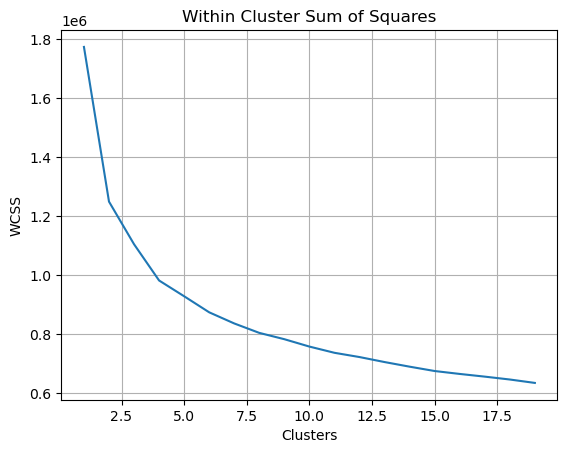

In [13]:
X = df_zscore_mean.drop(columns=['Age', 'wRC+', 'Name']) # dont include age 

wcss = []
for i in range(1,20):
    kmeans_clust = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans_clust.fit(X)
    wcss.append(kmeans_clust.inertia_)

plt.plot(range(1,20), wcss)
plt.title('Within Cluster Sum of Squares')
plt.ylabel('WCSS')
plt.xlabel('Clusters')
plt.grid(True)
plt.show()

Player Clusters

In [14]:
model = KMeans(n_clusters=3, init="k-means++", n_init=1000, random_state=26)
labels = model.fit_predict(X)

c:\Users\dalto\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(


add to df_zscore

In [15]:
df_zscore_mean['Cluster'] = labels
df_zscore_mean.head()

,Name,Age,BB%,K%,BABIP,wRC+,BsR,Off,Def,WAR,O-Swing%,Z-Swing%,O-Contact%,Z-Contact%,Contact%,SwStr%,CSW%,Cluster
0,aaron altherr,93.808311,104.510145,114.231522,96.136902,93.029960,98.675482,95.289196,100.250639,93.070213,94.967148,96.272788,82.195828,93.355267,88.079818,107.925073,114.907219,2
1,aaron boone,106.400260,95.780668,101.951313,93.271971,94.776379,104.052491,94.988424,97.367055,93.726959,106.187633,104.301387,95.100792,96.595751,94.063344,106.917349,102.397593,1
2,aaron guiel,100.658484,94.402057,106.355457,98.133049,94.878875,97.954852,96.101870,93.762117,90.995018,96.861566,89.119650,97.696468,97.844851,98.359004,99.011337,113.564518,1
3,aaron hicks,98.842860,113.751491,101.640918,93.046277,97.572693,103.745152,98.207022,99.469928,96.237675,86.062350,94.676678,96.856369,94.266039,97.187386,97.823301,101.994543,1
4,aaron hill,99.242720,95.701256,92.578100,95.116214,96.626687,101.295676,96.659472,102.585095,98.971084,96.208911,98.956655,101.699481,107.156488,106.307768,94.224316,95.910101,0


#### Cluster Means

In [16]:
cluster_means = df_zscore_mean.groupby('Cluster').mean(numeric_only=True)
cluster_means.head()

,Age,BB%,K%,BABIP,wRC+,BsR,Off,Def,WAR,O-Swing%,Z-Swing%,O-Contact%,Z-Contact%,Contact%,SwStr%,CSW%
Cluster,,,,,,,,,,,,,,,,
0,99.329686,96.731174,93.141074,97.841218,95.334736,100.063547,96.051809,101.845972,96.375696,99.733310,96.973245,107.629925,107.632224,108.219894,92.593301,95.814471
1,98.372002,100.448956,104.780560,99.397411,97.409161,99.765635,97.772033,99.110625,96.085559,99.374552,99.839684,95.479568,96.789285,96.146457,103.017197,103.885075
2,96.382673,97.036252,115.588727,100.465639,94.548853,99.121171,95.571004,99.449612,93.652872,106.061110,106.677934,86.945453,85.048869,84.349548,116.493656,111.333418


cluster count

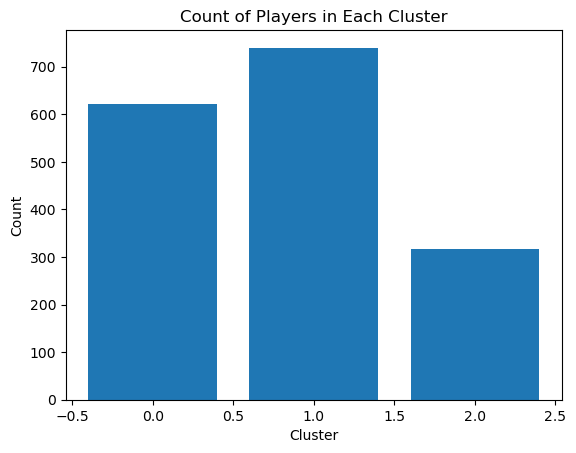

In [17]:
# Count the number of players in each cluster
cluster_counts = df_zscore_mean['Cluster'].value_counts()

# Plot the counts as a bar chart
plt.bar(cluster_counts.index, cluster_counts.values)
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.title('Count of Players in Each Cluster')
plt.show()

cluster v. wrc+

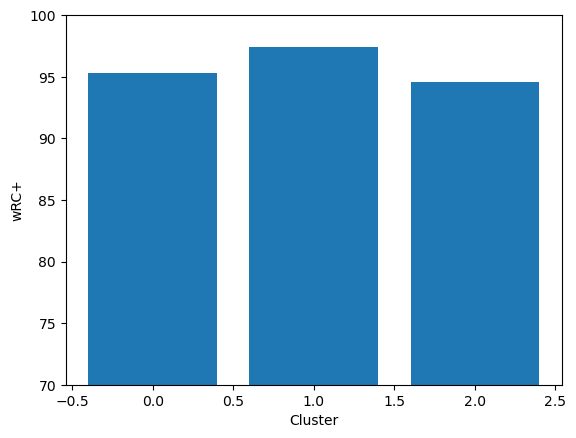

In [18]:
plt.bar(x=cluster_means.index, height=cluster_means['wRC+'])
plt.ylim(70, 100)
plt.xlabel('Cluster')
plt.ylabel('wRC+')
plt.show()

clusters to players

In [31]:
# Create a dictionary mapping player names to their clusters
name_to_cluster = df_zscore_mean.set_index('Name')['Cluster'].to_dict()

# Map the clusters to the df_zscore DataFrame
df_zscore['Cluster'] = df_zscore['Name'].map(name_to_cluster)

weighted avg based on cluster and pa

In [32]:
# Initialize an empty DataFrame to store cluster means by age
cluster_means_age = pd.DataFrame()

# Create a copy of df_zscore and add the Age column from df
df_zscore_age = df_zscore.copy()
df_zscore_age['Age'] = df['Age']

# Loop through each group of Age and Cluster
for (age, cluster), group in df_zscore_age.groupby(['Age', 'Cluster']):
    weighted_means = {}
    for col in group.select_dtypes(include=[np.number]).columns:
        if col != 'PA':  # Skip PA column for weighted means
            weighted_means[col] = np.average(group[col], weights=group['PA'])
    weighted_means['Age'] = age
    weighted_means['Cluster'] = cluster
    cluster_means_age = pd.concat([cluster_means_age, pd.DataFrame([weighted_means])], ignore_index=True)

cluster_means_age = cluster_means_age.sort_values(by=['Age', 'Cluster']).reset_index(drop=True)

overall average for age

In [ ]:
age_values = pd.DataFrame()
for col in df.select_dtypes(include=[np.number]).columns:
    if col != 'Season' and col != 'MLBAMID':  
        age_mean = df.groupby('Age')[col].apply(mean_year)
        age_values[col] = age_mean
age_values = age_values.reset_index(drop=True)

wrc+, by cluster, by age
<br>
<small> thanks gemeni for smoothing

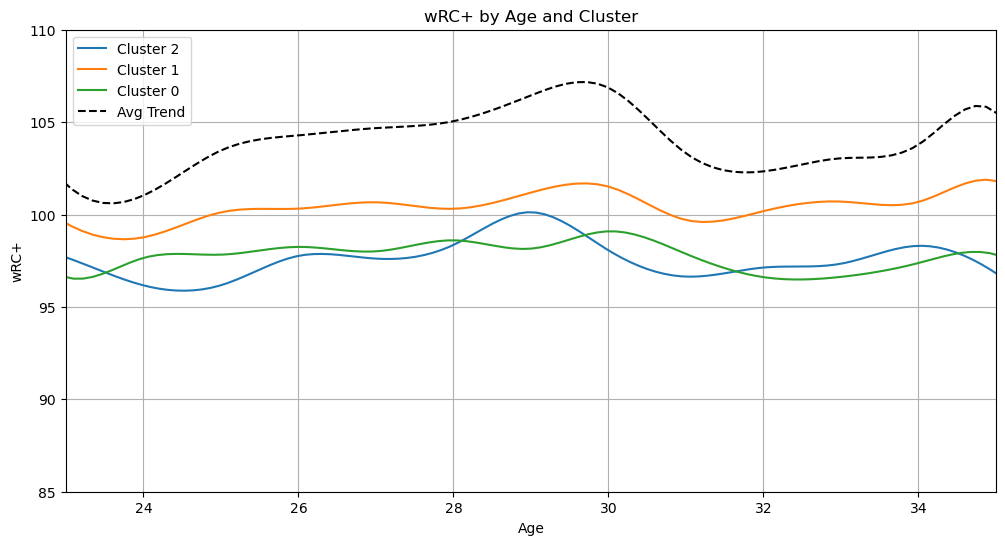

In [46]:
from scipy.interpolate import make_interp_spline
import numpy as np

# global averages
global_means = age_values[['Age','wRC+']]

# Plot wRC+ by age for each cluster
plt.figure(figsize=(12, 6))
for cluster in df_zscore_age['Cluster'].unique():
    cluster_data = cluster_means_age.loc[cluster_means_age['Cluster'] == cluster].set_index('Age')['wRC+']
    ages = cluster_data.index.get_level_values('Age')
    values = cluster_data.values
    # Smooth the trend line
    if len(ages) > 3:  # Ensure enough points for smoothing
        spline = make_interp_spline(ages, values, k=3)
        smooth_ages = np.linspace(ages.min(), ages.max(), 200)
        smooth_values = spline(smooth_ages)
        plt.plot(smooth_ages, smooth_values, label=f'Cluster {cluster}')
    else:
        plt.plot(ages, values, label=f'Cluster {cluster}')

# Smooth the global average trend line
ages = global_means['Age']
values = global_means['wRC+']
spline = make_interp_spline(ages, values, k=3)
smooth_ages = np.linspace(ages.min(), ages.max(), 200)
smooth_values = spline(smooth_ages)
plt.plot(smooth_ages, smooth_values, label='Avg Trend', linestyle='--', color='black')

plt.xlabel('Age')
plt.xlim(23, 35)
plt.ylim(85, 110)
plt.ylabel('wRC+')
plt.title('wRC+ by Age and Cluster')
plt.legend()
plt.grid(True)
plt.show()

looking at this numerically

In [ ]:
# Calculate the percentage change in wRC+ for each cluster
cluster_means_age['y/y wrc+'] = cluster_means_age.groupby('Cluster')['wRC+'].pct_change() * 100
global_means['y/y global'] = global_means['wRC+'].pct_change() * 100

# global mean and cluster wrc+
cluster_wrc = cluster_means_age[['Age', 'Cluster', 'y/y wrc+']]
cluster_wrc = cluster_wrc.merge(global_means, on='Age', how='outer')
cluster_wrc = cluster_wrc.drop


# sort
cluster_wrc = cluster_wrc.sort_values(['Cluster', 'Age'])
cluster_wrc.head()


C:\Users\dalto\AppData\Local\Temp\ipykernel_11480\3086426791.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  global_means['y/y global'] = global_means['wRC+'].pct_change() * 100


,Age,Cluster,y/y wrc+,wRC+,y/y global
0,19,0,NaN,126.534462,NaN
2,20,0,-7.827168,114.211237,-9.739027
5,21,0,-2.348114,105.946797,-7.236100
8,22,0,1.872428,106.116658,0.160326
11,23,0,-2.404564,101.642133,-4.216609
